In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# RK4 Method
def rk4(f, y0, t0, t_end, h):
    n_steps = int((t_end - t0) / h)
    t_values = [t0] 
    y_values = [y0] 
   
    t = t0
    y = y0
    for _ in range(n_steps):
        k1 = f(t,y) 
        k2 = f(t + h/2, y + (h/2)*k1)
        k3 = f(t + h/2, y + (h/2)*k2)
        k4 = f(t + h, y + h*k3)
        y = y + (h/6)*(k1 + 2*k2 + 2*k3 + k4) 
        t = t + h           
        t_values.append(t)  
        y_values.append(y)
   
    return t_values, y_values

In [6]:
# System Solver
def rk4_system(f, y0, t0, t_end, h):
    n_steps = int((t_end - t0) / h) 
    t_values = [t0] 
    y_values = np.zeros((n_steps + 1, len(y0)))
    y_values[0] = y0 
   
    t = t0
    for i in range(n_steps): 
        k1 = f(t,y_values[i]) 
        k2 = f(t + h/2, y_values[i] + (h/2)*k1)
        k3 = f(t + h/2, y_values[i] + (h/2)*k2)
        k4 = f(t + h, y_values[i] + h*k3)
        y_values[i+1] = y_values[i] + (h/6)*(k1 + 2*k2 + 2*k3 + k4) 
        t = t + h       
        t_values.append(t) 
   
    return t_values, y_values
    

In [35]:
# Parameter Calculation (refer to paper for explanation)
def calculate_alpha_delta(recovery, d):
    alpha = (1-d) / recovery
    delta = (alpha * d) / (1 - d)
    
    return alpha, delta

def calculate_beta(alpha, delta, s0, i0, s_inf):
    beta = (alpha + delta) * np.log(s0 / s_inf) / (i0 + s0 + s_inf)
    
    return beta


# Calculations (for paper)
alpha_gfc, delta_gfc = calculate_alpha_delta(180, 0.15)
beta_gfc = calculate_beta(alpha_gfc, delta_gfc, 0.95, 0.05, 0.1)
print("GFC Parameters:")
print(alpha_gfc, delta_gfc, beta_gfc)

alpha_dotcom, delta_dotcom = calculate_alpha_delta(180, 0.11)
beta_dotcom = calculate_beta(alpha_dotcom, delta_dotcom, 0.97, 0.03, 0.05)
print("Dotcom Parameters:")
print(alpha_dotcom, delta_dotcom, beta_dotcom)

alpha_afc, delta_afc = calculate_alpha_delta(180, 0.17)
beta_afc = calculate_beta(alpha_afc, delta_afc, 0.96, 0.04, 0.15)
print("AFC Parameters:")
print(alpha_afc, delta_afc, beta_afc)

GFC Parameters:
0.004722222222222222 0.0008333333333333333 0.0113701605990227
Dotcom Parameters:
0.004944444444444445 0.0006111111111111111 0.015689275481848054
AFC Parameters:
0.004611111111111111 0.0009444444444444445 0.008967623141862929


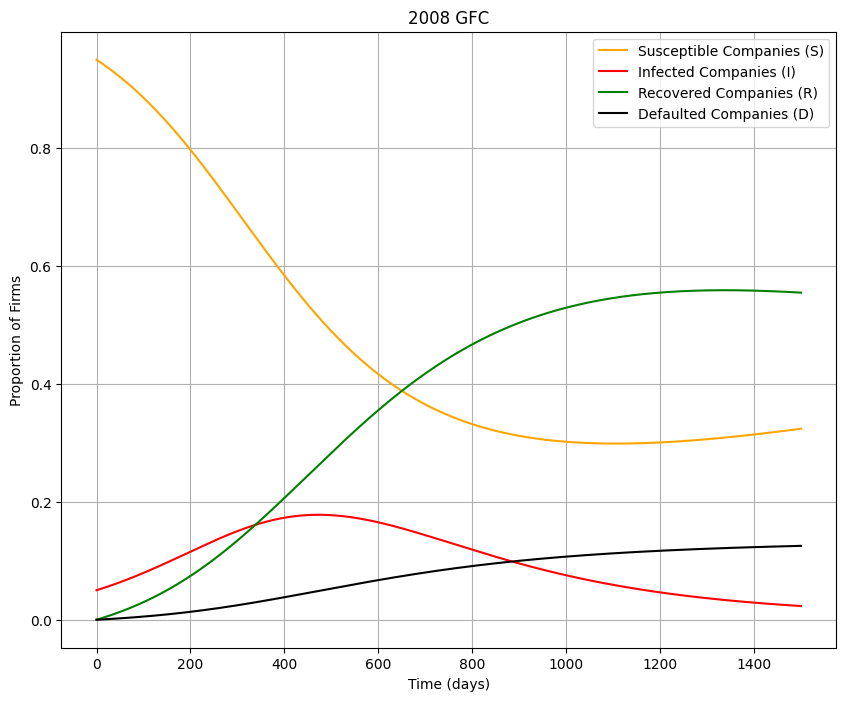

Final Values after 1500 days:
GFC - Susceptible: 0.3240, Infected: 0.0232, Recovered: 0.5548, Defaulted: 0.1253
Peak of Infection:
GFC - Day: 472.60, Infected Proportion: 0.1780


In [ ]:


def gfc_system(t, sird):
    s,i,r, d = sird
    
    # Assumptions
    growth_rate = 0.10307
    default_rate = 0.134
    s0 = 0.95
    i0 = 0.05
    s_inf = 0.1
    
    # Parameters
    mu = growth_rate / 365                                      # Natural growth/death rate
    alpha, delta = calculate_alpha_delta(180, default_rate)     # Recovery and default rates
    beta = calculate_beta(alpha, delta, s0, i0, s_inf)          # Infection rate
    
    # System
    dSdt = mu*(1-s) - beta*s*i
    dIdt = beta*s*i - (alpha + delta + mu)*i
    dRdt = alpha*i - mu*r
    dDdt = delta*i
    
    return np.array([dSdt, dIdt, dRdt, dDdt])

sird0_gfc = np.array([0.95,0.05,0,0])
t0 = 0
t_end = 1500
h = 0.1

t_gfc, SIRD_gfc = rk4_system(gfc_system, sird0_gfc, t0, t_end, h)

plt.figure(figsize=(10,8))
plt.plot(t_gfc, SIRD_gfc[:,0], label='Susceptible Companies (S)', color='orange')
plt.plot(t_gfc, SIRD_gfc[:,1], label='Infected Companies (I)', color='red')
plt.plot(t_gfc, SIRD_gfc[:,2], label='Recovered Companies (R)', color='green')
plt.plot(t_gfc, SIRD_gfc[:,3], label='Defaulted Companies (D)', color='black')
plt.title('2008 GFC')
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Firms')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

print("Final Values after 1500 days:")
print(f"GFC - Susceptible: {SIRD_gfc[-1,0]:.4f}, Infected: {SIRD_gfc[-1,1]:.4f}, Recovered: {SIRD_gfc[-1,2]:.4f}, Defaulted: {SIRD_gfc[-1,3]:.4f}")
print("Peak of Infection:")
peak_index_gfc = np.argmax(SIRD_gfc[:,1])
print(f"GFC - Day: {t_gfc[peak_index_gfc]:.2f}, Infected Proportion: {SIRD_gfc[peak_index_gfc,1]:.4f}")

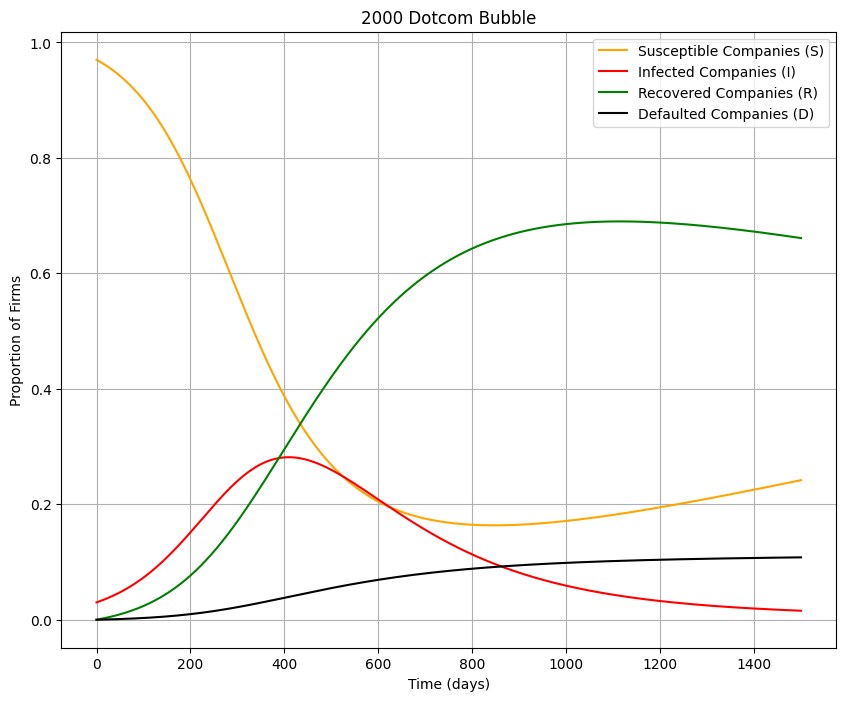

Final Values after 1500 days:
Dotcom - Susceptible: 0.2417, Infected: 0.0156, Recovered: 0.6610, Defaulted: 0.1080
Peak of Infection:
Dotcom - Day: 409.30, Infected Proportion: 0.2815


In [31]:

# 2000 Dotcom Bubble

def dotcom_system(t, sird):
    s,i,r,d = sird
    
    # Assumptions
    growth_rate = 0.10848
    default_rate = 0.11
    s0 = 0.97
    i0 = 0.03
    s_inf = 0.05
    
    
    # Parameters
    mu = growth_rate / 365                                      # Natural growth/death rate
    alpha, delta = calculate_alpha_delta(180, default_rate)     # Recovery and default rates
    beta = calculate_beta(alpha, delta, s0, i0, s_inf)          # Infection rate
    
    # System
    dSdt = mu*(1-s) - beta*s*i
    dIdt = beta*s*i - (alpha + delta + mu)*i
    dRdt = alpha*i - mu*r
    dDdt = delta*i
    
    return np.array([dSdt, dIdt, dRdt, dDdt])

sird0_dotcom = np.array([0.97,0.03,0,0])
t0 = 0
t_end = 1500
h = 0.1

t_dotcom, SIRD_dotcom = rk4_system(dotcom_system, sird0_dotcom, t0, t_end, h)


plt.figure(figsize=(10,8))
plt.plot(t_dotcom, SIRD_dotcom[:,0], label='Susceptible Companies (S)', color='orange')
plt.plot(t_dotcom, SIRD_dotcom[:,1], label='Infected Companies (I)', color='red')
plt.plot(t_dotcom, SIRD_dotcom[:,2], label='Recovered Companies (R)', color='green')
plt.plot(t_dotcom, SIRD_dotcom[:,3], label='Defaulted Companies (D)', color='black')
plt.title('2000 Dotcom Bubble')
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Firms')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

print("Final Values after 1500 days:")
print(f"Dotcom - Susceptible: {SIRD_dotcom[-1,0]:.4f}, Infected: {SIRD_dotcom[-1,1]:.4f}, Recovered: {SIRD_dotcom[-1,2]:.4f}, Defaulted: {SIRD_dotcom[-1,3]:.4f}")
print("Peak of Infection:")
peak_index_dotcom = np.argmax(SIRD_dotcom[:,1])
print(f"Dotcom - Day: {t_dotcom[peak_index_dotcom]:.2f}, Infected Proportion: {SIRD_dotcom[peak_index_dotcom,1]:.4f}")

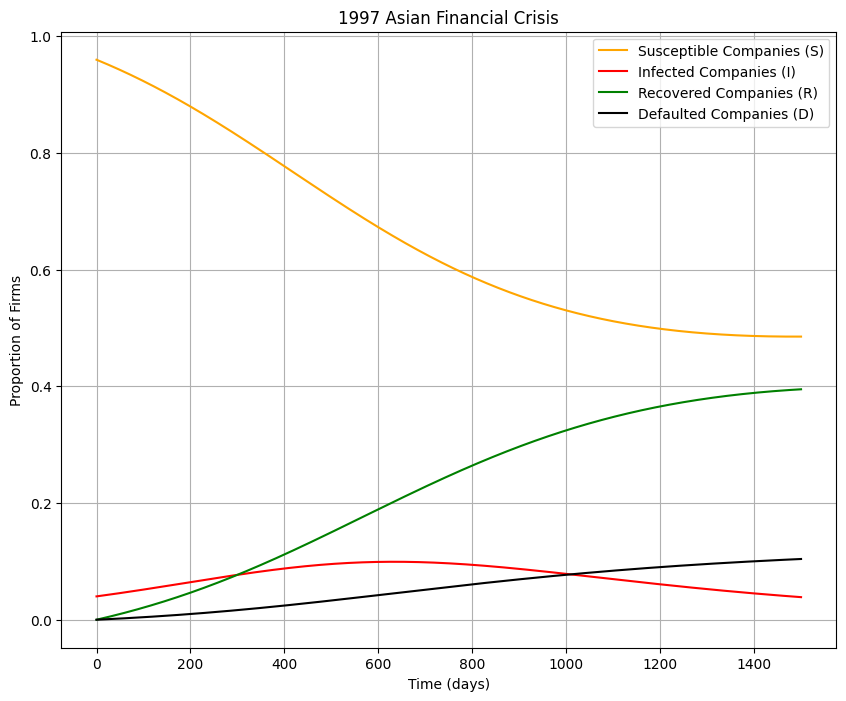

Final Values after 1500 days:
AFC - Susceptible: 0.4854, Infected: 0.0387, Recovered: 0.3950, Defaulted: 0.1041
Peak of Infection:
AFC - Day: 633.50, Infected Proportion: 0.0993


In [36]:

def asia_system(t, sird):
    s,i,r,d = sird
    
    # Assumptions
    growth_rate = 0.122
    default_rate = 0.17
    s0 = 0.96
    i0 = 0.04
    s_inf = 0.15
    
    # Parameters
    mu = growth_rate / 365                                      # Natural growth/death rate
    alpha, delta = calculate_alpha_delta(180, default_rate)     # Recovery and default rates
    beta = calculate_beta(alpha, delta, s0, i0, s_inf)          # Infection rate
    
    # System
    dSdt = mu*(1-s) - beta*s*i
    dIdt = beta*s*i - (alpha + delta + mu)*i
    dRdt = alpha*i - mu*r
    dDdt = delta*i
    
    return np.array([dSdt, dIdt, dRdt, dDdt])

sird0_afc = np.array([0.96,0.04,0,0])
t0 = 0
t_end = 1500
h = 0.1

t_afc, SIRD_afc = rk4_system(asia_system, sird0_afc, t0, t_end, h)

plt.figure(figsize=(10,8))
plt.plot(t_afc, SIRD_afc[:,0], label='Susceptible Companies (S)', color='orange')
plt.plot(t_afc, SIRD_afc[:,1], label='Infected Companies (I)', color='red')
plt.plot(t_afc, SIRD_afc[:,2], label='Recovered Companies (R)', color='green')
plt.plot(t_afc, SIRD_afc[:,3], label='Defaulted Companies (D)', color='black')
plt.title('1997 Asian Financial Crisis')
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Firms')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

print("Final Values after 1500 days:")
print(f"AFC - Susceptible: {SIRD_afc[-1,0]:.4f}, Infected: {SIRD_afc[-1,1]:.4f}, Recovered: {SIRD_afc[-1,2]:.4f}, Defaulted: {SIRD_afc[-1,3]:.4f}")
print("Peak of Infection:")
peak_index_afc = np.argmax(SIRD_afc[:,1])
print(f"AFC - Day: {t_afc[peak_index_afc]:.2f}, Infected Proportion: {SIRD_afc[peak_index_afc,1]:.4f}")